In [1]:
import os, sys
BASE_PATH = os.path.dirname(os.path.abspath(''))
sys.path.append(BASE_PATH)

In [2]:
import glob, random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

from lib.proc import to_hwc
BASE_DIR = 'D:/Projects/python/dataset/inria'

# view sample

In [3]:
import rasterio as rs
image_fps = glob.glob(f'{BASE_DIR}/images/*.tif')
print(image_fps)

['D:/Projects/python/dataset/inria/images\\austin1.tif', 'D:/Projects/python/dataset/inria/images\\chicago1.tif', 'D:/Projects/python/dataset/inria/images\\vienna1.tif']


In [4]:
raster = rs.open(image_fps[0])
raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 5000,
 'height': 5000,
 'count': 3,
 'crs': CRS.from_epsg(26914),
 'transform': Affine(0.29999999999997673, 0.0, 616500.0,
        0.0, -0.30000000000009314, 3345000.0)}

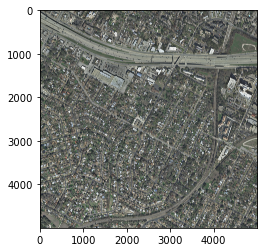

In [7]:
image = to_hwc(raster.read())
plt.imshow(image)

In [8]:
raster_mask = rs.open(image_fps[0].replace('images', 'gt'))
raster_mask.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 5000,
 'height': 5000,
 'count': 1,
 'crs': CRS.from_epsg(26914),
 'transform': Affine(0.3, 0.0, 616500.0,
        0.0, -0.3, 3345000.0)}

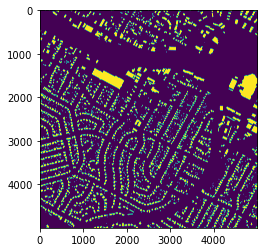

In [9]:
mask = to_hwc(raster_mask.read())
plt.imshow(mask)

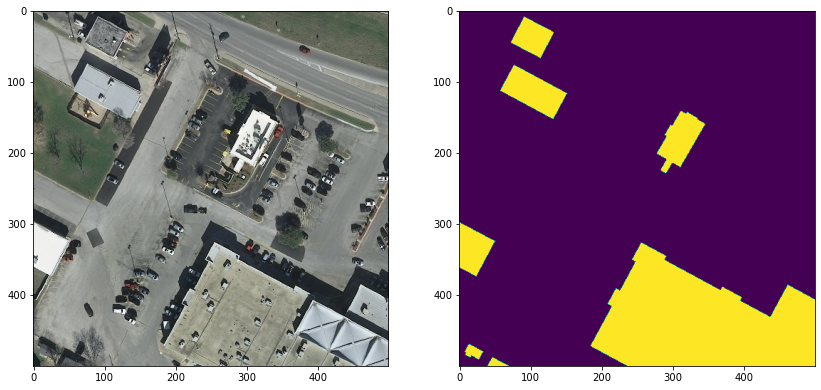

In [10]:
r0 = 1000
r1 = 1500
c0 = 1000
c1 = 1500

f, [ax1,ax2] = plt.subplots(1,2,figsize=(14,7))
ax1.imshow(image[r0:r1,c0:c1,:])
ax2.imshow(mask[r0:r1,c0:c1,0])
plt.show()

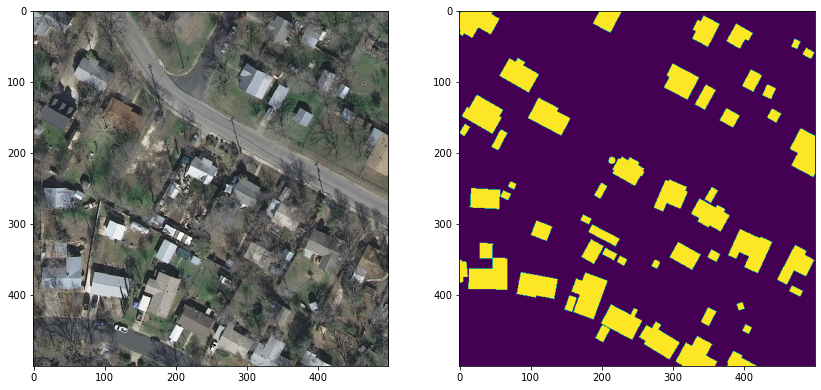

In [11]:
r0 = 2000
r1 = 2500
c0 = 1000
c1 = 1500

f, [ax1,ax2] = plt.subplots(1,2,figsize=(14,7))
ax1.imshow(image[r0:r1,c0:c1,:])
ax2.imshow(mask[r0:r1,c0:c1,0])
plt.show()

# Tiling
- resolution: 5000x5000
- covering 1500x1500
- spatial res: 30cm/px
- SN6 is 50cm/px -> 900x900 res
- take 1000x1000 image tile

In [3]:
train_city = ['austin','chicago']
n_train = 1 # 30
val_city = ['vienna']
n_val = 1 # 10

In [4]:
def get_city_fps(city_list, n_tile):
    fps = []
    for city in city_list:
        city_fps = glob.glob(f'{BASE_DIR}/images/{city}*.tif')
        random.shuffle(city_fps)
        for city_fp in city_fps[:n_tile]:
            fps.append(city_fp)
    return fps

train_fps = get_city_fps(train_city, n_train)
val_fps = get_city_fps(val_city, n_val)

## image way

In [7]:
def tile_image(out_dir, fp):
    w = 1000
    h = 1000
    images = []
    with Image.open(fp) as img:
        image = np.array(img.convert('L'))
        # tile into 25
        for i in range(5):
            for j in range(5):
                images.append(image[i*w:(i+1)*w, j*h:(j+1)*h])

    return images

images = tile_image('', train_fps[0])
len(images)

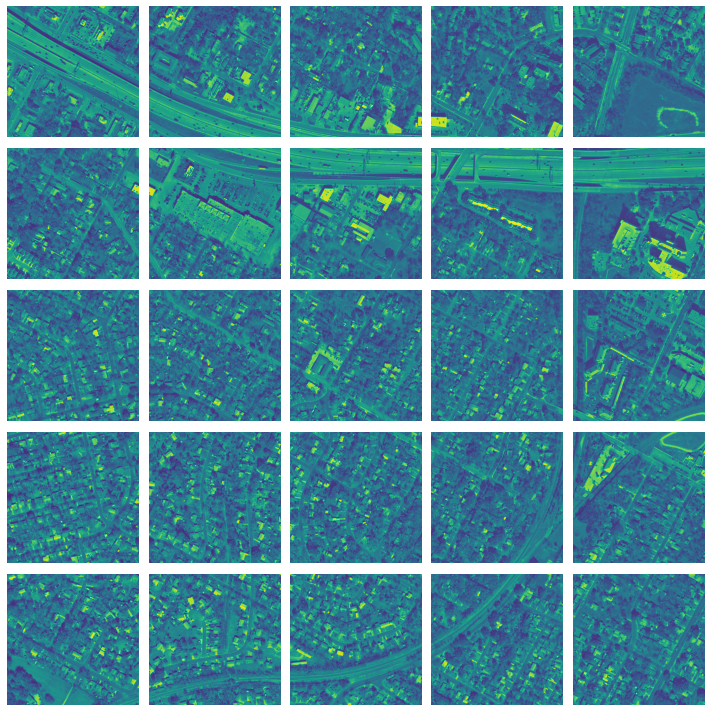

In [10]:
f = plt.figure(figsize=(10,10))
for i in range(25):
    ax = f.add_subplot(5,5,i+1)
    ax.imshow(images[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

### tile and save

In [22]:
out_dir = 'preds'

def tile_image(out_dir, fp):
    w = 1000
    h = 1000
    if not os.path.isdir(out_dir):
        os.makedirs(out_dir)

    with Image.open(fp) as img:
        fn = os.path.basename(fp).split('.')[0]
        image = np.array(img.convert('L'))
        # tile into 25
        count = 0
        for i in range(5):
            for j in range(5):
                im = Image.fromarray(image[i*w:(i+1)*w, j*h:(j+1)*h])
                im.save(f'{out_dir}/{fn}_{str(count).zfill(2)}.png')
                count += 1

for train_fp in train_fps:
    tile_image(f'{out_dir}/train/images', train_fp)
    tile_image(f'{out_dir}/train/gt', train_fp.replace('images','gt'))

# for val_fp in val_fps:
#     tile_image(f'{out_dir}/val/images', val_fp)
#     tile_image(f'{out_dir}/val/gt', val_fp.replace('images','gt'))


## geospatial way

In [11]:
from solaris.raster_tile import RasterTiler

In [18]:
OUT_DIR = 'test'
tile_size = (1000,1000)

def tile_city(out_dir, tile_size, fps):
    for fp in fps:
        # create tiler object
        raster_tiler = RasterTiler(
            dest_dir=out_dir,
            src_tile_size=tile_size,
            verbose=0,
        )

        # tile image raster
        raster_tiler.dest_dir = f'{out_dir}/images'
        raster_tiler.tile(fp)

        # tile label raster
        raster_tiler.dest_dir = f'{out_dir}/gt'
        raster_tiler.tile(fp.replace('images','gt'))

tile_city(f'{OUT_DIR}/train', tile_size, train_fps)
tile_city(f'{OUT_DIR}/val', tile_size, val_fps)

2it [00:00, 12.68it/s]

tiling 30 tiles


30it [00:01, 17.17it/s]
30it [00:01, 26.02it/s]
2it [00:00, 14.94it/s]

tiling 25 tiles


25it [00:01, 20.46it/s]
25it [00:01, 24.85it/s]


### cleaning up

In [19]:
# despite equal division, some image tiles have empty data
# find empty images from train and val folder, delete along with the label pair
tile_fps = glob.glob(f'{OUT_DIR}/*/images/*.tif')
print(len(tile_fps))

80


In [25]:
empty_fps = []

for tile_fp in tile_fps:
    with Image.open(tile_fp) as img:
        image = np.array(img)
        if np.min(image) == np.max(image):
            empty_fps.append(tile_fp)

print(len(empty_fps))

i = 0
for empty_fp in empty_fps:
    os.remove(empty_fp)
    os.remove(empty_fp.replace('images','gt'))
    i += 1
print(f'removed {i} tile pairs')

5
removed 5 tile pairs


# TFrecord
name will be


```
'train_o0-00-50.tfrec'
'val_o0-00-50.tfrec'
```

```
train
    images
    gt
val
    images
    gt
```

- 750 tiles for train, 15 large tile from austin, 15 large tile from Vienna
- 250 tiles for val, 10 large tile from Chicago

In [26]:
import tensorflow as tf

In [27]:
train_tile_fps = glob.glob(f'{OUT_DIR}/train/images/*.tif')
val_tile_fps = glob.glob(f'{OUT_DIR}/val/images/*.tif')

print(f'train: {len(train_tile_fps)}, val: {len(val_tile_fps)}')

train: 50, val: 25


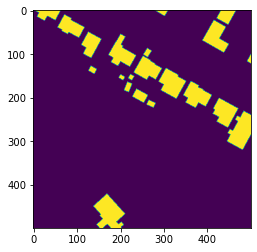

In [18]:
raster = Image.open(train_fps[0].replace('images','gt').replace('result','label'))
image = np.array(raster.convert('L'))
raster.close()
plt.imshow(image)

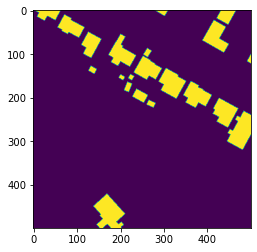

In [19]:
raster = Image.open(train_fps[0].replace('images','gt').replace('result','label'))
image = np.array(raster.convert('1'))
raster.close()
plt.imshow(image)

In [28]:
def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList won't unpack a string from an EagerTensor. intended for the image data
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

def get_serialized_image_label(raster_path):
    """returns image and label in tf serial tensor
    """
    raster = Image.open(raster_path)
    image = np.array(raster.convert('L'))   # to grayscale
    raster.close()

    # data_region_idx not required here, but used just to comply with code from SN6
    h = image.shape[0]
    w = image.shape[1]
    data_region_idx = [0,h,0,w]

    # serialize image
    image_tensor = tf.constant(image, dtype=tf.float32)
    image_serial = tf.io.serialize_tensor(image_tensor)

    # read label
    raster_label = Image.open(raster_path.replace('images','gt'))
    label = np.array(raster_label.convert('1'))   # to bool
    raster_label.close()

    # serialize label
    label_tensor = tf.constant(label, dtype=tf.bool)
    label_serial = tf.io.serialize_tensor(label_tensor)
    return image_serial, label_serial, data_region_idx

def create_tfrecord(raster_paths, size, base_fn):
    """
    image in float32 serialized
    mask in binary serialized
    size : int
    output : tfrecord with filenames: '{base_fn}01-{size}.tfrec'
    """
    tot_ex = len(raster_paths)  # total examples
    tot_tf = int(np.ceil(tot_ex/size))  # total tfrecords

    for i in range(tot_tf):
        print(f'Writing TFRecord {i} of {tot_tf}..')
        size2 = min(size, tot_ex - i*size)  # size=size2 unless for remaining in last file
        fn = f'{base_fn}-{i:02}-{size2}.tfrec'

        with tf.io.TFRecordWriter(fn) as writer:
            for j in range(size2):
                idx = i*size+j  # ith tfrec * num_img per tfrec as the start of this iteration
                image, label, data_region_idx = get_serialized_image_label(
                    raster_paths[idx])

                fn = os.path.basename(raster_paths[idx]).split('.')[0]

                feature = {
                    'image': _bytes_feature(image.numpy()),
                    'label': _bytes_feature(label.numpy()),
                    'data_idx': _int64_feature(data_region_idx),
                    'fn' : _bytes_feature(tf.compat.as_bytes(fn)),
                    'orient': _int64_feature([0]),
                }

                # write tfrecords
                example = tf.train.Example(features=tf.train.Features(feature=feature))
                writer.write(example.SerializeToString())

In [32]:
create_tfrecord(train_tile_fps, 10, f'{OUT_DIR}/train_o0')
create_tfrecord(val_tile_fps, 10, f'{OUT_DIR}/val_o0')

Writing TFRecord 0 of 5..
Writing TFRecord 1 of 5..
Writing TFRecord 2 of 5..
Writing TFRecord 3 of 5..
Writing TFRecord 4 of 5..
Writing TFRecord 0 of 3..
Writing TFRecord 1 of 3..
Writing TFRecord 2 of 3..


loading test\train_o0-00-10.tfrec


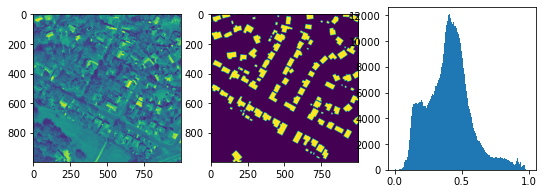

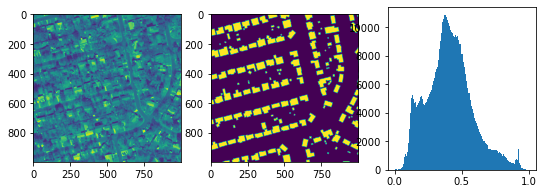

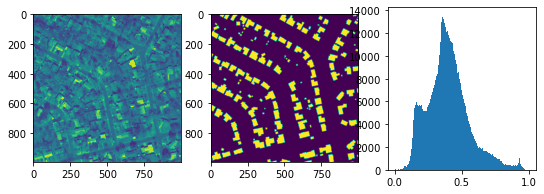

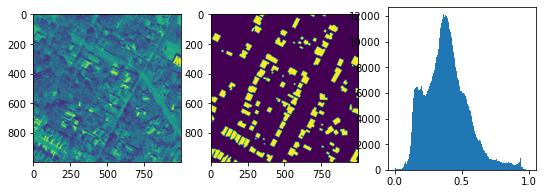

shape: (1000, 1000, 1)
   min  max    mean       std     pos  zero  neg  nan
0  0.0  1.0  0.3872  0.158841  999910    90    0    0
b'austin1_0003'


In [33]:
from lib.viz import show_stats, show_hist

def test_tfrec(show=4):
    TFREC_FORMAT = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.string),
        'data_idx': tf.io.VarLenFeature(tf.int64),
        'fn': tf.io.FixedLenFeature([], tf.string),
        'orient': tf.io.FixedLenFeature([], tf.int64),
    }

    def _read_tfrecord(feature):
        features = tf.io.parse_single_example(feature, TFREC_FORMAT)
        image = tf.io.parse_tensor(features["image"], tf.float32)
        label = tf.io.parse_tensor(features["label"], tf.bool)
        label = tf.cast(label, tf.float32)

        data_idx = tf.sparse.to_dense(features["data_idx"])
        h = data_idx[1] - data_idx[0]
        w = data_idx[3] - data_idx[2]
        image = tf.reshape(image, [h, w, 1])
        label = tf.reshape(label, [h, w, 1])

        image = tf.math.divide(image, tf.math.reduce_max(image))
        fn = features['fn']

        return image, label, fn

    filenames = glob.glob(os.path.join(OUT_DIR, f'*.tfrec'))
    filename = filenames[0]
    print(f'loading {filename}')
    ds = tf.data.TFRecordDataset([filename])
    ds = ds.map(_read_tfrecord)

    for img, label, fn in ds.take(show):
        f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(9,3))
        ax1.imshow(img.numpy()[:,:,0])
        ax2.imshow(label.numpy()[:,:,0])
        show_hist(img.numpy(),ax=ax3)
        plt.show()
    
    show_stats(img.numpy())
    print(fn.numpy())

test_tfrec()

# train

In [3]:
import tensorflow as tf
from lib.viz import show_stats, show_hist

fns = glob.glob('../../image_folder/processed/inria/train*.tfrec')
len(fns)

15

### why it's negative?

In [12]:
TFREC_FORMAT = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'label': tf.io.FixedLenFeature([], tf.string),
    'data_idx': tf.io.VarLenFeature(tf.int64),
    'fn': tf.io.FixedLenFeature([], tf.string),
    'orient': tf.io.FixedLenFeature([], tf.int64),
}

def read_tfrecord(feature):
    # read tfrecord features
    features = tf.io.parse_single_example(feature, TFREC_FORMAT)
    image = tf.io.parse_tensor(features['image'], tf.float32)
    label = tf.io.parse_tensor(features['label'], tf.bool)
    label = tf.cast(label, tf.float32)

    data_idx = tf.sparse.to_dense(features['data_idx'])
    h = data_idx[1] - data_idx[0]
    w = data_idx[3] - data_idx[2]
    
    # return shape information (lost during serialization)
    image = tf.reshape(image, [h, w, 1])
    label = tf.reshape(label, [h, w, 1])

    # normalize so max value is 1.0
    image = tf.math.divide(image, tf.math.reduce_max(image))

    # reduce image resolution to target_res
    # image, label = self.reduce_fun(image, label)

    return image, label, features['fn']

In [20]:
inria_fns = ['../../image_folder/processed/inria/train_o0-00-50.tfrec']
pan_fns = ['../../image_folder/processed/pan/fold0_o1-00-50.tfrec']
sar_fns = ['../../image_folder/sn6-crop/fold0_o1-00-50.tfrec']

In [28]:
5%10

5

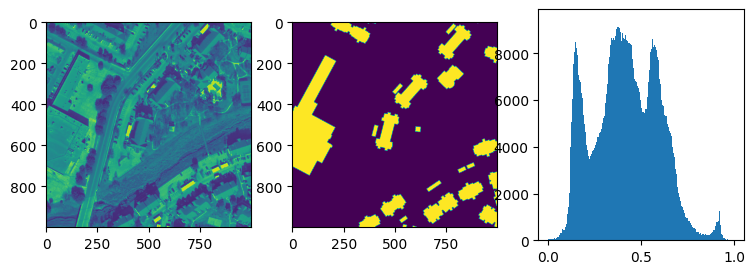

<dtype: 'float32'>
<dtype: 'float32'>
[  0. 255.]
shape: (1000, 1000, 1)
   min  max      mean       std     pos  zero  neg  nan
0  0.0  1.0  0.419501  0.175093  999929    71    0    0


In [24]:
inria_ds = tf.data.TFRecordDataset(inria_fns)
for img, label, fn in inria_ds.map(read_tfrecord).take(1):
    f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(9,3))
    ax1.imshow(img.numpy()[:,:,0])
    ax2.imshow(label.numpy()[:,:,0])
    show_hist(img.numpy(),ax=ax3)
    plt.show()

print(img.dtype)
print(label.dtype)
print(np.unique(label.numpy()))
show_stats(img.numpy())

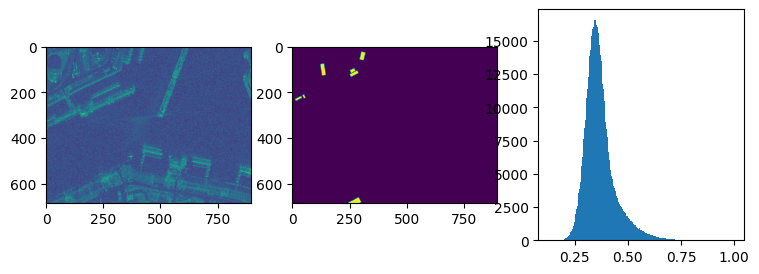

<dtype: 'float32'>
<dtype: 'float32'>
[0. 1.]
shape: (685, 898, 1)
        min  max      mean       std     pos  zero  neg  nan
0  0.123825  1.0  0.368642  0.072402  615130     0    0    0
shape: (685, 898, 1)
        min  max      mean       std     pos  zero  neg  nan
0  0.123825  1.0  0.368642  0.072402  615130     0    0    0


In [25]:
sar_ds = tf.data.TFRecordDataset(sar_fns)
for img, label, fn in sar_ds.map(read_tfrecord).take(1):
    f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(9,3))
    ax1.imshow(img.numpy()[:,:,0])
    ax2.imshow(label.numpy()[:,:,0])
    show_hist(img.numpy(),ax=ax3)
    plt.show()

print(img.dtype)
print(label.dtype)
print(np.unique(label.numpy()))
show_stats(img.numpy())
show_stats(img.numpy())

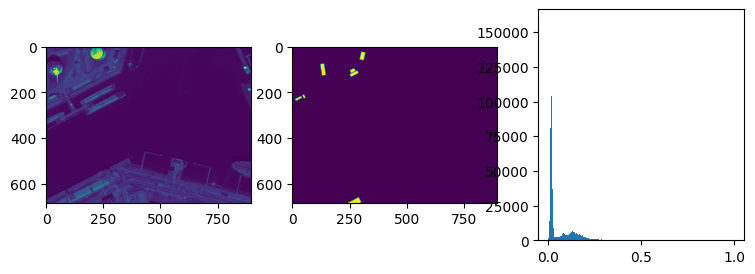

shape: (685, 898, 1)
       min  max      mean      std     pos  zero  neg  nan
0  0.00054  1.0  0.063852  0.08941  615130     0    0    0


In [21]:
pan_ds = tf.data.TFRecordDataset(pan_fns)
for img, label, fn in pan_ds.map(read_tfrecord).take(1):
    f,[ax1,ax2,ax3] = plt.subplots(1,3,figsize=(9,3))
    ax1.imshow(img.numpy()[:,:,0])
    ax2.imshow(label.numpy()[:,:,0])
    show_hist(img.numpy(),ax=ax3)
    plt.show()

show_stats(img.numpy())

### training

In [4]:
from sn6.model import BFE

Segmentation Models: using `keras` framework.
Learning rate schedule: 0.0032 to 0.0032 to 3e-06


In [5]:
tr_cfg = {
    # dataset cfg
    'IMAGE_RS'      : 320,          # target resolution
    'TRAIN_PATH'    : '../../image_folder/processed/inria',    # kaggle ds name
    'TRAIN_SPLITS'  : ['train'],               # folds used for training
    'VAL_PATH'      : '../../image_folder/processed/inria',    # if None, don't validate
    'VAL_SPLITS'    : ['val'],    # folds used for validation
    'SAR_CH'        : [1],          # HH=1, HV=2, VH=3, VV=4. use None to read all channel
    'ORIENT'        : 0,
    
    # model cfg
    'BACKBONE'      : 'effb4',      # 'effb4', 'res50'
    'ARC'           : 'fpn',        # 'unet', 'fpn'
    'WEIGHT'        : None,         # 'imagenet', 'pre-trained from:..', None
    
    # training cfg
    'SEED'          : 17,
    'BATCH_SIZE'    : 8,
    'SHUFFLE_BUFFER': 150,
    'EPOCHS'        : 15,
    'LF'            : 'dice',       # 'bce', 'jaccard_distance', 'focal', 'giou'
    'L_RATE'        : 32e-4,        # 32e-4, 4e-4, 5e-5
    'IS_CV'         : 0,            # cross validation
    'IS_3_FOLD'     : 0,            # do same training 3x to get an average value
    'IS_CB_ES'      : 0,            # early stopping
    'IS_CB_LRS'     : 1,            # learning rate scheduler, if false uses lr_ramp
    
    # reduce method: 'resize', 'pad_resize', 'random_crop', 'random_crop_resize'
    'REDUCE_RES'    : 'pad_resize',
    'COMB_REDUCE'   : True, # when using rand_crop or rand_crop_resize, randomize reduce method with pad_resize
    'VAL_REDUCE_RES': 'pad_resize',

    # spatial transformations
    'IS_HFLIP'      : 0,
    'IS_VFLIP'      : 0,
    'IS_ROT90'      : 0,
    'IS_FINE_ROT'   : 0,
    'IS_SHEAR_X'    : 0,
    'IS_SHEAR_Y'    : 0,

    # aug magnitude
    'ROT_REFLECT'   : 0,
    'ROT_RANGE'     : [-10, 10],
    'SHEAR_RANGE'   : [-10, 10],

    # pixel transformations
    'IS_MOT_BLUR'   : 0,
    'IS_SHARPEN'    : 0,
    'IS_CLAHE'      : 0,
    'IS_GAUS_NOISE' : 0,
    'IS_SPECKLE_NOISE': 0,
    'IS_COARSE_DO'  : 0,

    # offline augs
    'OFF_DS'        : '',   # 'elee', 'frost', 'gmap' NOT ADOPTED YET
    'OFF_AUG_PATH'  : '',
}

loading the fpn_effb4 model..
Total params: 20,915,833


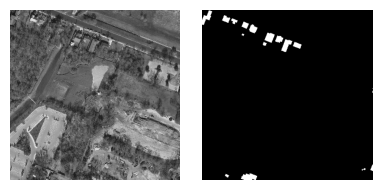

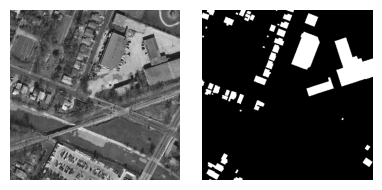

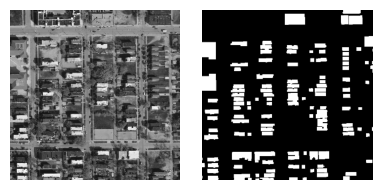

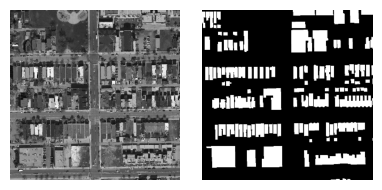

starting training..
Epoch 1/15
93/93 [==============================] - 65s 492ms/step - loss: 0.5077 - iou_score: 0.3318 - f1-score: 0.4947 - val_loss: 0.9999 - val_iou_score: 4.1225e-11 - val_f1-score: 4.1225e-11 - lr: 0.0032
Epoch 2/15
93/93 [==============================] - 44s 479ms/step - loss: 0.4128 - iou_score: 0.4178 - f1-score: 0.5879 - val_loss: 0.9999 - val_iou_score: 4.1163e-11 - val_f1-score: 4.1163e-11 - lr: 0.0032
Epoch 3/15
93/93 [==============================] - 45s 484ms/step - loss: 0.3726 - iou_score: 0.4592 - f1-score: 0.6280 - val_loss: 0.9999 - val_iou_score: 4.1350e-11 - val_f1-score: 4.1350e-11 - lr: 0.0032
Epoch 4/15
93/93 [==============================] - 45s 484ms/step - loss: 0.3441 - iou_score: 0.4894 - f1-score: 0.6564 - val_loss: 1.0000 - val_iou_score: 4.1155e-11 - val_f1-score: 4.1155e-11 - lr: 0.0032
Epoch 5/15
93/93 [==============================] - ETA: 0s - loss: 0.3250 - iou_score: 0.5111 - f1-score: 0.6754

KeyboardInterrupt: 

In [6]:
model = BFE(tr_cfg)
#     model.log_wandb('sn6_test', 'inria-reduce', run)
model.load_model()
model.load_data()
model.dataloader.preview_train_ds(n_show=4, n_rep=1, min_view=True)
model.train(verbose=1)
model.view_results(n_show=6)